In [36]:
# Step 0: Install and import libraries
!pip install pennylane tensorflow imbalanced-learn scikit-learn matplotlib

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow as tf
import pennylane as qml
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("/content/creditcard.csv")

# Features and labels
X = df.drop(columns=["Time", "Class"])
y = df["Class"]

In [39]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_scaled_imputed = imputer.fit_transform(X_scaled)

# PCA to 8 components for 8 qubits
pca = PCA(n_components=28)
X_pca = pca.fit_transform(X_scaled_imputed)
print(f"PCA Explained Variance: {pca.explained_variance_ratio_}")

PCA Explained Variance: [0.06923055 0.0550545  0.05026256 0.0457551  0.04391867 0.04059265
 0.03917467 0.03777585]


In [40]:
X_cleaned = X_pca[~np.isnan(y)]
y_cleaned = y[~np.isnan(y)]

# SMOTE for class balancing
smote = SMOTE(random_state=42, k_neighbors=2)
X_balanced, y_balanced = smote.fit_resample(X_cleaned, y_cleaned)
print(f"Balanced class distribution: {dict(zip(*np.unique(y_balanced, return_counts=True)))}")


Balanced class distribution: {np.float64(0.0): np.int64(166151), np.float64(1.0): np.int64(166151)}


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

y_train = y_train.to_numpy().flatten()
y_test = y_test.to_numpy().flatten()


In [42]:
import pennylane as qml
import tensorflow as tf

n_qubits = 28
dev = qml.device("default.qubit", wires=n_qubits)

# QNode
def quantum_circuit(inputs, weights_conv, weights_pool):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights_conv, wires=range(n_qubits))

    # Quantum pooling example
    for i in range(0, n_qubits, 2):
        qml.CNOT(wires=[i, i+1])
        qml.RY(weights_pool[i//2], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits//2)]

In [43]:
weight_shapes = {
    "weights_conv": (2, n_qubits, 3),
    "weights_pool": (n_qubits//2,)
}

# Wrap QNode into a Keras Layer
qnode = qml.QNode(quantum_circuit, dev, interface="tf")

class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        # Trainable weights
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        return self.qnode(inputs, self.weights_conv, self.weights_pool)

In [44]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.qnode = qnode
        self.weights_conv = tf.Variable(tf.random.normal(shape=weight_shapes["weights_conv"]), trainable=True)
        self.weights_pool = tf.Variable(tf.random.normal(shape=weight_shapes["weights_pool"]), trainable=True)

    def call(self, inputs):
        outputs = self.qnode(inputs, self.weights_conv, self.weights_pool)  # List of expectation values
        # Convert list to tensor of shape (batch_size, n_qubits//2)
        return tf.stack(outputs, axis=1)


In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),  # Ensure input shape is correct (12)
    tf.keras.layers.Dense(64, activation='relu'),  # Temporarily replace quantum layer with a dense layer
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [46]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,      # Colab-friendly
    batch_size=32
)

Epoch 1/50
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9235 - loss: 0.1929 - precision_3: 0.9708 - recall_3: 0.8750 - val_accuracy: 0.9544 - val_loss: 0.1251 - val_precision_3: 0.9814 - val_recall_3: 0.9267
Epoch 2/50
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9558 - loss: 0.1150 - precision_3: 0.9806 - recall_3: 0.9300 - val_accuracy: 0.9638 - val_loss: 0.0963 - val_precision_3: 0.9813 - val_recall_3: 0.9459
Epoch 3/50
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9657 - loss: 0.0901 - precision_3: 0.9812 - recall_3: 0.9494 - val_accuracy: 0.9673 - val_loss: 0.0823 - val_precision_3: 0.9844 - val_recall_3: 0.9499
Epoch 4/50
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9711 - loss: 0.0753 - precision_3: 0.9818 - recall_3: 0.9600 - val_accuracy: 0.9732 - val_loss: 0.0705 - val_precision_3: 0.9753 - val_recall_3: 0.9711
Epoch 5/50
6646/6646 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9753 - loss: 0.0657 - precision_3: 0.9823 - rec

In [47]:
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"\n✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"✅ Test Precision: {precision * 100:.2f}%")
print(f"✅ Test Recall: {recall * 100:.2f}%")
print(f"✅ Test F1 Score: {f1 * 100:.2f}%")
print(f"\nConfusion Matrix:\n{conf_matrix}")

2077/2077 ━━━━━━━━━━━━━━━━━━━━ 2s 954us/step

✅ Test Loss: 0.0158
✅ Test Accuracy: 99.65%
✅ Test Precision: 99.30%
✅ Test Recall: 100.00%
✅ Test F1 Score: 99.65%

Confusion Matrix:
[[32997   234]
 [    0 33230]]


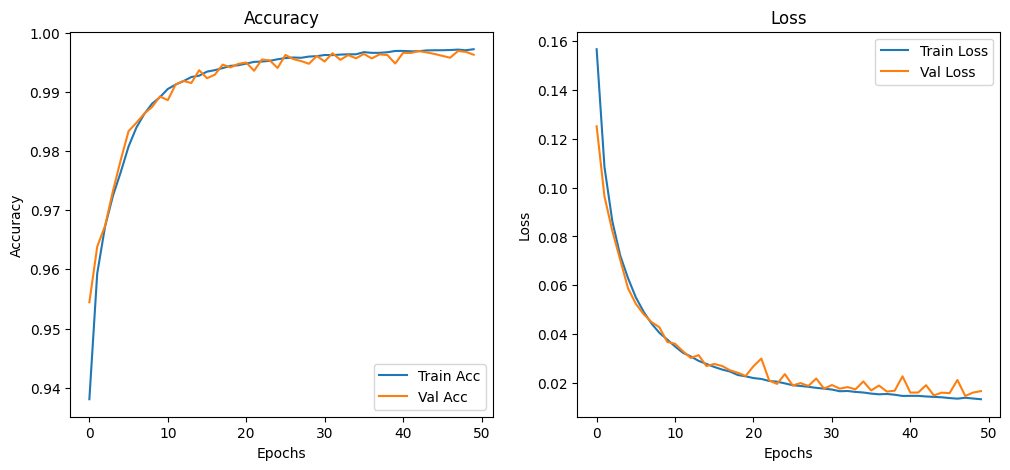

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()